In [1]:
# embedding matice má v řádcích embeddingy (1 řádek - 1 token)
# vizualizovat umapem a olabelovat páry

In [2]:
checkpoint_path = "/home/p23131/rl/rl_basic_transformer/data/cc/2c0s52s0/checkpoints/epoch=999-step=2294905.ckpt"

In [3]:
import wandb

In [4]:
import torch
from lightning import LightningModule
from models import GPT, GPTConfig, CausalSelfAttention
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

class NanoGPT(LightningModule):
    def __init__(
        self,
        vocab_size: int,
        block_size: int,
        n_layer: int = None,
        n_head: int = None,
        n_embd: int = None,
        dropout: float = 0.0,
        weight_decay: float = 0.1,
        learning_rate: float = 3e-4,
        betas: tuple = (0.9, 0.95)
    ):
        super().__init__()
        self.betas = betas
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.config = GPTConfig(vocab_size=vocab_size, block_size=block_size, n_layer=n_layer, n_head=n_head, n_embd=n_embd, dropout=dropout)
        self.gpt = GPT(self.config)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        return self.gpt(idx, targets)

    def get_attention_map(self, idx: torch.Tensor):
        """
        Get the attention map for a single example.
        """
        self.attention_map = None

        def hook_fn(module, input, output):
            self.attention_map = output[1].detach() 

        first_attn_layer = self.gpt.transformer.h[0].attn
        handle = first_attn_layer.register_forward_hook(hook_fn)

        # Forward pass
        with torch.no_grad():
            self(idx)

        # Remove the hook
        handle.remove()

        return self.attention_map
## FCE:

def load_trained_model(checkpoint_path, vocab_size, block_size, n_layer, n_head, n_embd):
    model = NanoGPT(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=n_layer,
        n_head=n_head,
        n_embd=n_embd
    )
    
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
    
    return model
    
def load_data(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

In [5]:
loaded_model = load_trained_model(
    checkpoint_path,
    vocab_size=64,
    block_size=8,
    n_layer=2,
    n_head=1,
    n_embd=128,
)
print("Model loaded from local checkpoint")

input_ids = torch.randint(0, 64, (1, 8))  # Random input
with torch.no_grad():
    output, _ = loaded_model(input_ids)
print("Output shape:", output.shape)

number of parameters: 0.40M
Model loaded from local checkpoint
Output shape: torch.Size([1, 1, 64])


In [6]:
data = load_data("data_c.pkl")
test_data = data["test"]

In [7]:
def inference_on_test_set(model, test_data):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = len(test_data)
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for sample in test_data:
            input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
            true_output = sample['out']
            
            input_ids = input_ids.to(next(model.parameters()).device)
            
            logits, _ = model(input_ids)
            predicted_output = logits.argmax(dim=-1).item()
            
            correct_predictions += (predicted_output == true_output)
            
            predictions.append(predicted_output)
            true_labels.append(true_output)
    
    accuracy = correct_predictions / total_samples
    return accuracy, predictions, true_labels

In [8]:
accuracy,_,_= inference_on_test_set(loaded_model, test_data)
accuracy

0.49166666666666664

In [9]:
def inference_on_single_sample(model, sample):
    model.eval()  # Set the model to evaluation mode
    
    input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
    true_output = sample['out']
    
    input_ids = input_ids.to(next(model.parameters()).device)
    
    with torch.no_grad():
        logits, _ = model(input_ids)
        predicted_output = logits.argmax(dim=-1).item()
    
    is_correct = (predicted_output == true_output)
    
    return is_correct, f"{predicted_output=}", f"{true_output=}"


In [10]:
loaded_model.gpt.transformer.wte.weight.shape

torch.Size([64, 128])

In [11]:
loaded_model.gpt.transformer.wte.weight

Parameter containing:
tensor([[ 1.6111e-02, -1.0490e-01, -7.2937e-03,  ..., -3.9512e-03,
          2.4304e-03, -6.9271e-02],
        [-8.6120e-02, -5.1985e-02, -5.3927e-02,  ...,  6.1688e-02,
          2.8630e-02, -2.6868e-02],
        [-2.6274e-02, -9.0139e-02, -3.1300e-03,  ...,  3.5326e-02,
          5.7187e-02, -1.0750e-01],
        ...,
        [-4.3434e-02,  4.4114e-02, -3.2946e-03,  ...,  5.8283e-03,
         -2.1370e-02,  4.9644e-02],
        [ 2.5956e-02,  3.6344e-03,  3.5530e-05,  ..., -6.2361e-05,
          1.3617e-05,  2.6193e-02],
        [ 2.5958e-02,  3.6364e-03,  3.5454e-05,  ..., -6.2328e-05,
          1.3587e-05,  2.6198e-02]], requires_grad=True)

In [12]:
loaded_model.gpt.transformer.h[0].attn

CausalSelfAttention(
  (c_attn): Linear(in_features=128, out_features=384, bias=True)
  (c_proj): Linear(in_features=128, out_features=128, bias=True)
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
)

In [13]:
loaded_model

NanoGPT(
  (gpt): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(64, 128)
      (wpe): Embedding(8, 128)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-1): 2 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=128, out_features=384, bias=True)
            (c_proj): Linear(in_features=128, out_features=128, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=128, out_features=512, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=128, out_features=64, bias=False)
  )
)

In [14]:
index = 21

In [15]:
test_data[index]["input"]

[52, 27, 30, 16, 19, 29, 10]

In [16]:
test_data[index]["orig_idx"]

4

In [17]:
inference_on_single_sample(loaded_model, test_data[index])

(False, 'predicted_output=56', 'true_output=59')

/home/p23131/.conda/envs/rl_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 1, 7, 7])
torch.Size([7, 7])
tensor([[0.0000, 0.1840, 0.1092, 0.0888, 0.1290, 0.2079, 0.2811],
        [0.0543, 0.0000, 0.0703, 0.0568, 0.3442, 0.2608, 0.2136],
        [0.0338, 0.2401, 0.0000, 0.0273, 0.0631, 0.5443, 0.0915],
        [0.1663, 0.1905, 0.1239, 0.0000, 0.1258, 0.2173, 0.1762],
        [0.1242, 0.2968, 0.0510, 0.1036, 0.0000, 0.1413, 0.2831],
        [0.0168, 0.4680, 0.1808, 0.0138, 0.1499, 0.0000, 0.1707],
        [0.0646, 0.3735, 0.0714, 0.0900, 0.1583, 0.2422, 0.0000]])


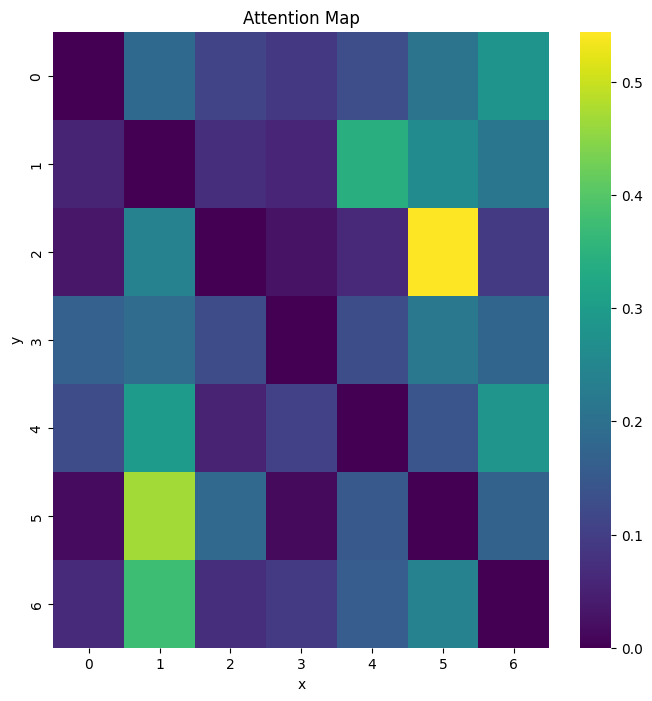

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_attention_map(model, input_ids):
    model.eval()
    with torch.no_grad():
        attention = model.get_attention_map(input_ids)
    print(attention.shape)
    attention = attention.squeeze()
    print(attention.shape)
    print(attention)

    plt.figure(figsize=(8, 8))
    sns.heatmap(attention, cmap='viridis')
    plt.title("Attention Map")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

input_ids = torch.tensor(test_data[index]["input"]).unsqueeze(0)
visualize_attention_map(loaded_model, input_ids)

In [19]:
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings.shape

torch.Size([64, 128])

In [20]:
import umap
from sklearn.decomposition import PCA
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings = embeddings.detach().numpy()[:55]

def get_embedding_umap(embeddings):
    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

def get_embedding_pca(embeddings):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    return pca_embeddings

# Call the functions to get UMAP and PCA embeddings
umap_embeddings = get_embedding_umap(embeddings)
pca_embeddings = get_embedding_pca(embeddings)

# Print the shapes of the embeddings
print(f"UMAP embeddings shape: {umap_embeddings.shape}")
print(f"PCA embeddings shape: {pca_embeddings.shape}")


UMAP embeddings shape: (55, 2)
PCA embeddings shape: (55, 2)


In [21]:
embeddings

array([[ 0.01611063, -0.10490172, -0.00729365, ..., -0.00395119,
         0.00243039, -0.06927059],
       [-0.08612044, -0.05198502, -0.05392678, ...,  0.06168848,
         0.02862957, -0.02686808],
       [-0.02627383, -0.09013883, -0.00312999, ...,  0.03532565,
         0.05718737, -0.10750037],
       ...,
       [-0.06283478,  0.09498034,  0.02766854, ..., -0.11228663,
        -0.04203188, -0.01662639],
       [-0.03743157, -0.01100004,  0.00957425, ..., -0.06656834,
         0.06095458, -0.0629537 ],
       [-0.0016901 ,  0.02746777,  0.06494456, ..., -0.08254172,
         0.04619834, -0.07829171]], dtype=float32)

In [22]:
embeddings.shape

(55, 128)

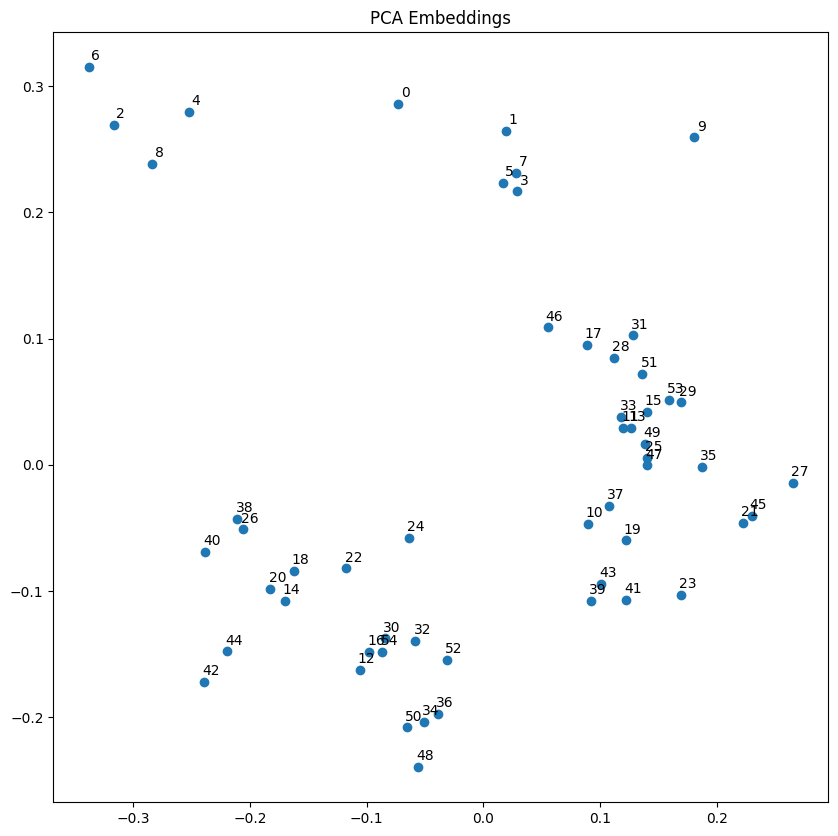

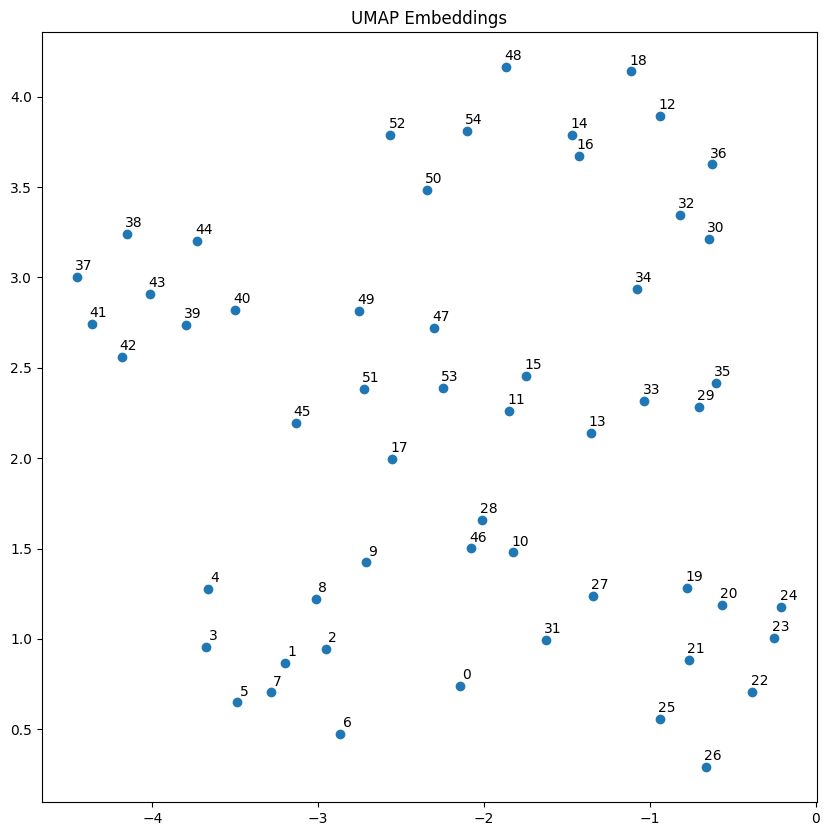

In [23]:
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    plt.title(title)
    labels = list(range(len(embeddings)))
    for i in range(len(embeddings)):
        plt.annotate(labels[i], (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.show()

# Call the function to visualize the PCA embeddings
visualize_embeddings(pca_embeddings, "PCA Embeddings")
visualize_embeddings(umap_embeddings, "UMAP Embeddings")